# Temperature Quantile Theory variation with latitude
This notebook looks at trying to estimate the temperature above a given quantile using each of four theories. It looks at how each of these theories work over different latitudes.

It looks at the difference between the $\kappa=2$ and $\kappa=1$ simulations because both of these simulations are convectively neutral on the hottest and average summer days in the extratropics.

In this notebook, the mean refers to the summer **ocean** mean in the given latitude bin.

In [2]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-02-09 15:44:09,821 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset
exp_dir = 'tau_sweep/land/meridional_band/bucket/'
var_keep = ['temp', 'sphum', 'height', 'cape', 'cin']
tau_lw_ref = 1
tau_lw_warm = 2
exp_names = [f'k={tau_lw_ref}', f'k={tau_lw_warm}']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]  # only keep variables required - quicker to load and less memory
    ds += [ds_use]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

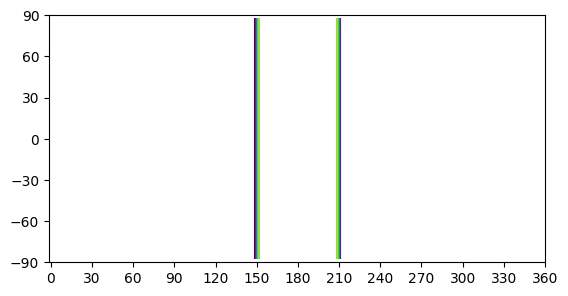

In [4]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get one dataset, `ds_quant`, for land, for each latitude bin averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the ocean summer for a given latitude bin.

In [5]:
## Split datasets into land and ocean ones
ds_all = {'land':[], 'ocean': []}
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
for i in range(n_exp):
    for surf in ['land', 'ocean']:
        ds_all[surf] += [ds[i].sel(lon=np.unique(lon[surf]), method='nearest')]

In [6]:
# Get data set averaged over all ocean summer days considering in each latitude bin.
# Do this for each optical depth value
use_time_start = 360*2

lat_width = 10
lat_min = np.arange(0, 90, lat_width)
lat_max = lat_min + lat_width
lat_centre = lat_min + lat_width/2  # Central absolute latitude for given latitude bin
n_lat = len(lat_min)

temp_summer_av = np.zeros((n_exp, n_lat))
ds_summer = [[], []]
for i in range(n_exp):
    ds_use = ds_all['ocean'][i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    for j in tqdm(range(n_lat)):
        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min[j], lat_max[j]))    # NH summer is JJA
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max[j], -lat_min[j]))    # SH summer is DJF
        # Combine hemispheres and average over longitude, time and latitude.
        ds_use2 = xr.concat([ds_nh_summer.mean(dim=('lon', 'time')), ds_sh_summer.mean(dim=('lon', 'time'))], dim='lat').mean(dim='lat')
        ds_summer[i] += [ds_use2]
        ds_summer[i][j].load()     # Load in averaged dataset so later computation and conversion to numpy is much quicker
        temp_summer_av[i, j] = ds_summer[i][j].temp[-1]

100%|██████████| 9/9 [00:29<00:00,  3.32s/it]


In [7]:
# Get land data set averaged over all days exceeding a given quantile of near surface temperature.
# Do this for each optical depth value and each latitude bin
quantile_use = 95
temp_quant = np.zeros((n_exp, n_lat))
ds_quant = [[], []]
for i in range(n_exp):
    ds_use = ds_all['land'][i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    for j in tqdm(range(n_lat)):
        ds_use2 = ds_use.where((np.abs(ds_use.lat) <= lat_max[j]) & (np.abs(ds_use.lat) >= lat_min[j]), drop=True)    # Only latitude region
        # Collapse to single coordinate and then take quantile over it
        ds_use2 = ds_use2.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        quantile_thresh = ds_use2.temp[-1].quantile(quantile_use/100, dim='lon_lat_time', keep_attrs=True)
        # Average each variable in data over days where near surface temperature exceeds this quantile
        ds_use2 = ds_use2.where(ds_use2.temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)
        ds_quant[i] += [ds_use2]
        ds_quant[i][j].load()  # Load in averaged dataset so later computation and conversion to numpy is much quicker

        # Record mean extratropical near surface temperature
        temp_quant[i, j] = ds_quant[i][j].temp[-1]

100%|██████████| 9/9 [01:24<00:00,  9.42s/it]


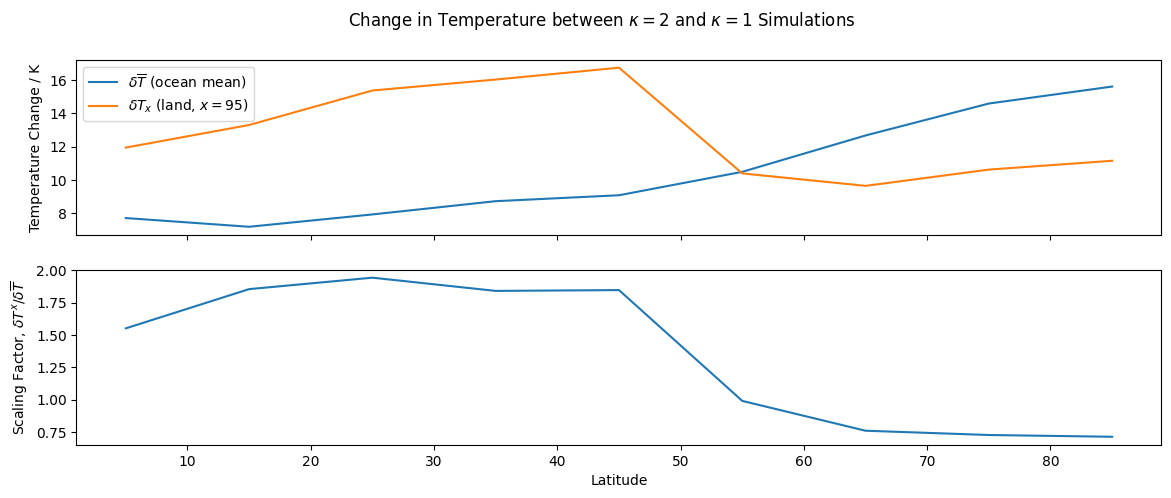

In [8]:
# In second plot here, normalise by change in the summer mean temperature
delta_temp_mean = temp_summer_av[1] - temp_summer_av[0]
delta_temp_quant = temp_quant[1]-temp_quant[0]
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(lat_centre, delta_temp_mean, label='$\delta \overline{T}$ (ocean mean)')
ax[0].plot(lat_centre, delta_temp_quant, label=f'$\delta T_x$ (land, $x={quantile_use}$)')
ax[0].set_ylabel('Temperature Change / K')
ax[0].legend()
ax[1].plot(lat_centre, delta_temp_quant/delta_temp_mean)
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Latitude')
plt.suptitle(f"Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

The blue line in the second plot above is different to Figure 2 of Byrne 2021 as it is the change in land $x$ percentile day divided by the local change in ocean mean day. In Byrne 2021, it is divided by the local change in land mean day.

## Theory for Temperature Change, $\delta T_x$ of days exceeding percentile $x$
This is trying to get a theory for the change in temperature of a given percentile day in a manor analagous to byrne 2021.

In [9]:
p_surface = float(ds_summer[0][0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

def sphum_surface_sat(temp):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), p_surface)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor(temp):
    # Alpha in byrne 2021
    return L_v / (R_v * temp**2)

# Get the average temperature between experiments for computing some of the parameters below
# Initially thought should use the mid point for this but actually in taylor series, you evaluate at lowest (k=1) value.,
# temp_mean_mid = np.mean(temp_summer_av)             # mean refers to summer mean
temp_mean_mid = temp_summer_av[0]
# temp_quant_mid = np.mean(temp_all_quant, axis=0)
temp_quant_mid = temp_quant[0]

In [10]:
# Compute constants required for theory
alpha_quant = clausius_clapeyron_factor(temp_quant_mid)
alpha_mean = clausius_clapeyron_factor(temp_mean_mid)
q_quant = np.asarray([np.asarray([ds_quant[i][j].sphum[-1] for j in range(n_lat)]) for i in range(n_exp)])
q_quant_mid = q_quant[0]
q_mean = np.asarray([np.asarray([ds_summer[i][j].sphum[-1] for j in range(n_lat)]) for i in range(n_exp)])
q_mean_mid = q_mean[0]
rh_quant = rh_from_sphum(q_quant,temp_quant,p_surface)/100
rh_mean = rh_from_sphum(q_mean,temp_summer_av,p_surface)/100

q_sat_quant = sphum_surface_sat(temp_quant_mid)
q_sat_mean = sphum_surface_sat(temp_mean_mid)

z_quant = np.asarray([np.asarray([ds_quant[i][j].height[-1] for j in range(n_lat)]) for i in range(n_exp)])
z_mean = np.asarray([np.asarray([ds_summer[i][j].height[-1] for j in range(n_lat)]) for i in range(n_exp)])

# Get difference in values between the two climates
delta_q_quant = q_quant[1] - q_quant[0]
delta_q_mean = q_mean[1] - q_mean[0]
delta_rh_quant = rh_quant[1] - rh_quant[0]
delta_rh_mean = rh_mean[1] - rh_mean[0]
delta_z_quant = z_quant[1] - z_quant[0]
delta_z_mean = z_mean[1] - z_mean[0]


In [11]:
# Compute the delta h* term based on the saturation MSE in the free troposphere
# Use 500hPa not 700hPa as with evap land because profile is still dry adiabat at that altitude with bucket model
# I.e. it hasn't saturated yet.
pressure_ft = 500
def mse_ft(dataset):
    # Calculate free troposphere saturated MSE for a given dataset in kJ/kg
    ds_use = dataset.sel(pfull=pressure_ft, method='nearest')
    pressure_ft_actual = ds_use.pfull * 100     # This is the pressure level closest to pressure_ft
    mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_use.temp), pressure_ft_actual)
    sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
    return moist_static_energy(ds_use.temp, sphum_sat, ds_use.height)

mse_quant = np.zeros((n_exp, n_lat))
mse_ft_sat_quant = np.zeros((n_exp, n_lat))
mse_summer = np.zeros((n_exp, n_lat))
mse_ft_sat_summer = np.zeros((n_exp, n_lat))
for i in range(n_exp):
    for j in range(n_lat):
        mse_summer[i, j] = moist_static_energy(ds_summer[i][j].temp[-1], ds_summer[i][j].sphum[-1], ds_summer[i][j].height[-1])
        mse_ft_sat_summer[i, j] = mse_ft(ds_summer[i][j])
        mse_quant[i, j] = moist_static_energy(ds_quant[i][j].temp[-1], ds_quant[i][j].sphum[-1], ds_quant[i][j].height[-1])
        mse_ft_sat_quant[i, j] = mse_ft(ds_quant[i][j])

mse_sat_diff = mse_ft_sat_quant - mse_ft_sat_summer
delta_mse_sat_diff = (mse_sat_diff[1] - mse_sat_diff[0]) * 1000   # *1000 so in units of J/kg

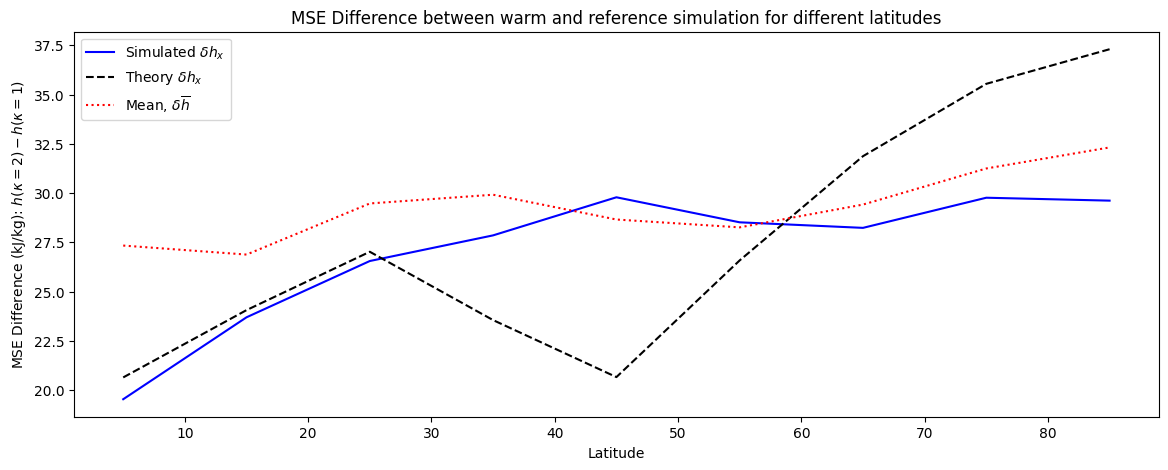

In [12]:
## Compare predicted MSE difference assuming convective neutrality to that from the theory
mse_quant_diff = mse_quant[1]-mse_quant[0]
mse_quant_diff_sim = (c_p * delta_temp_mean + L_v * delta_q_mean)/1000 + mse_sat_diff[1]-mse_sat_diff[0]
mse_summer_diff = mse_summer[1]-mse_summer[0]
fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True)
ax.plot(lat_centre, mse_quant_diff, color='blue', label='Simulated $\delta h_x$')
ax.plot(lat_centre, mse_quant_diff_sim, color='k', linestyle='--', label='Theory $\delta h_x$')
ax.plot(lat_centre, mse_summer_diff, color='r', linestyle=':', label='Mean, $\delta \overline{h}$')
ax.set_xlabel('Latitude')
ax.set_ylabel(f'MSE Difference (kJ/kg): $h(\kappa={tau_lw_warm})-h(\kappa={tau_lw_ref})$')
ax.set_title('MSE Difference between warm and reference simulation for different latitudes')
ax.legend();

### $\delta h$ Analysis

From above, we see that the theoretical $\delta h$ assuming convective neutrality so that $h = h_{FT}$ underestimates $\delta h$ up to about $50\degree$.

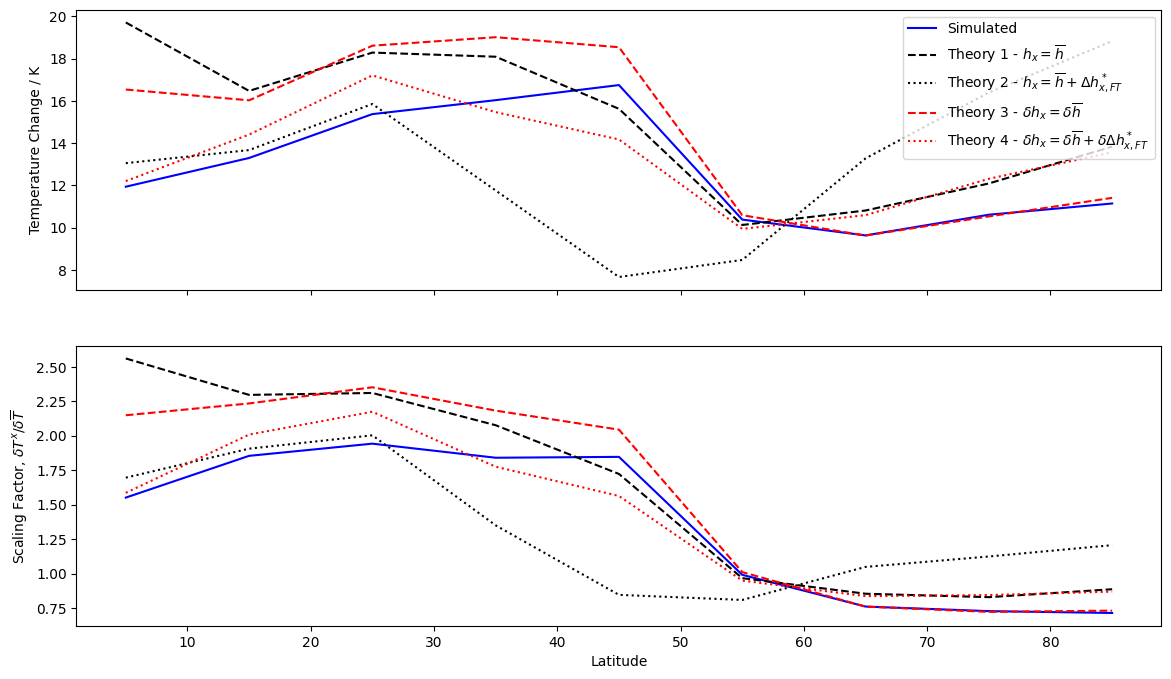

In [13]:
# Compared predicted temperature difference - Figure 2 of byrne 2021
delta_temp_quant_theory1 = delta_temp_mean + (L_v * (delta_q_mean - delta_q_quant) + g * (delta_z_mean-delta_z_quant))/c_p
delta_temp_quant_theory2 = delta_temp_quant_theory1 + delta_mse_sat_diff/c_p

denom = c_p + L_v * alpha_quant * (q_quant_mid + q_sat_quant * delta_rh_quant)
gamma_t = c_p + L_v * alpha_mean * (q_mean_mid + q_sat_mean * delta_rh_mean)

delta_temp_quant_theory3 = gamma_t * delta_temp_mean + L_v * (q_sat_mean * delta_rh_mean - q_sat_quant * delta_rh_quant) + \
                           g * (delta_z_mean - delta_z_quant)
delta_temp_quant_theory4 = delta_temp_quant_theory3 + delta_mse_sat_diff
delta_temp_quant_theory3 = delta_temp_quant_theory3 / denom
delta_temp_quant_theory4 = delta_temp_quant_theory4 / denom

# Consider adding non-linear term to theory temperature
# temp_diff_theory = temp_diff_theory + prefactor * gamma_nl * delta_rh_mean * delta_t_mean
fig, ax = plt.subplots(2,1, figsize=(14, 8), sharex=True)
ax[0].plot(lat_centre, delta_temp_quant, color='blue', label='Simulated')
ax[0].plot(lat_centre, delta_temp_quant_theory1, color='k', linestyle='--', label='Theory 1 - $h_x = \overline{h}$')
ax[0].plot(lat_centre, delta_temp_quant_theory2, color='k', linestyle=':', label='Theory 2 - $h_x = \overline{h} + \Delta h_{x,FT}^*$')
ax[0].plot(lat_centre, delta_temp_quant_theory3, color='r', linestyle='--', label='Theory 3 - $\delta h_x = \delta \overline{h}$')
ax[0].plot(lat_centre, delta_temp_quant_theory4, color='r', linestyle=':',
           label='Theory 4 - $\delta h_x = \delta \overline{h} + \delta \Delta h_{x,FT}^*$')
ax[1].plot(lat_centre, delta_temp_quant/delta_temp_mean, color='blue', label='Simulated')
ax[1].plot(lat_centre, delta_temp_quant_theory1/delta_temp_mean, color='k', linestyle='--', label='Theory 1')
ax[1].plot(lat_centre, delta_temp_quant_theory2/delta_temp_mean, color='k', linestyle=':', label='Theory 2')
ax[1].plot(lat_centre, delta_temp_quant_theory3/delta_temp_mean, color='r', linestyle='--', label='Theory 3')
ax[1].plot(lat_centre, delta_temp_quant_theory4/delta_temp_mean, color='r', linestyle=':', label='Theory 4')
ax[1].set_xlabel('Latitude')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[0].legend();

From the above plots, there are three striking features:
1. The least restrictive Theory 4 (red dotted) underestimates $\delta T_x$ at low latitudes, whereas at high latitudes where it overstimates $\delta T_x$. The underestimate at low latitudes is not seen in the aquaplanet simulation, but the overestimate at high latitudes is seen.
2. Theories 1 and 3 (dashed) transition from overestimate near the tropics to underestimate in the extratropics and then overestimate again at the largest latitudes. This is very similar to what is seen in the aquaplanet simulation.
2. Theory 2 (black dotted) follows the trend of Theory 4 but the absolute difference from the simulated (blue) value is always larger. In the aquaplanet simulation, we only clearly saw this effect at large latitudes.

### Feature 1
The only assumption of Theory 4 is that the lapse rate differs from the moist adiabat by some amount with this difference being allowed to change as the climate warms. But we assume the change to the mean and $x$ percentile days are the same.

We can write this in terms of MSE by saying that the saturated free troposphere and surface MSE differ by some amount which depends on the state of the climate, $\kappa$: $h_x = h^*_{x, FT} + \epsilon_x(\kappa)$ and $\overline{h} = \overline{h^*_{FT}} + \overline{\epsilon}(\kappa)$, or equally:
$$\Delta h_x = h_x - \overline{h} = h^*_{x, FT} - \overline{h^*_{FT}} + \epsilon_x(\kappa) - \overline{\epsilon}(\kappa) =
\Delta h^*_{x, FT} + \epsilon_x(\kappa) - \overline{\epsilon}(\kappa)$$

As we warm the climate (vary $\kappa$), we assume that both $\epsilon$ values change by the same amount: $\delta \epsilon_x = \delta \overline{\epsilon}$, which gives:

$$\delta \Delta h_x = \delta \Delta h^*_{x, FT} + \delta \epsilon_x - \delta \overline{\epsilon} = \delta \Delta h^*_{x, FT}$$

For Theory 4, the exact equation $\delta h_x = \delta \overline{h} + \delta \Delta h_x$ can thus be approximated as $\delta h_x = \delta \overline{h} + \delta \Delta h_{x, FT}^*$.

The $\delta \Delta h_{x, FT}^*$ contribution to the $\delta T_x$ estimate is equal to a positive constant multiplied by $\delta \Delta h_{x, FT}^*$. I.e. if $\delta \Delta h_{x, FT}^*$ is an overestimate of $\delta \Delta h_{x}$, then $\delta T_x$ will be overestimated.

From the bottom plot below, we see that $\delta \Delta h_{x, FT}^*$ is significantly larger than $\delta \Delta h_{x}$ for high latitudes, thus explaining why we see an overestimate of $\delta T_x$ at high latitudes for Theory 4.

We also see that $\delta \Delta h_{x, FT}^*$ is significantly smaller than $\delta \Delta h_{x}$ for basically all the low latitudes, thus explaining why we see an underestimate of $\delta T_x$ at low latitudes for Theory 4.

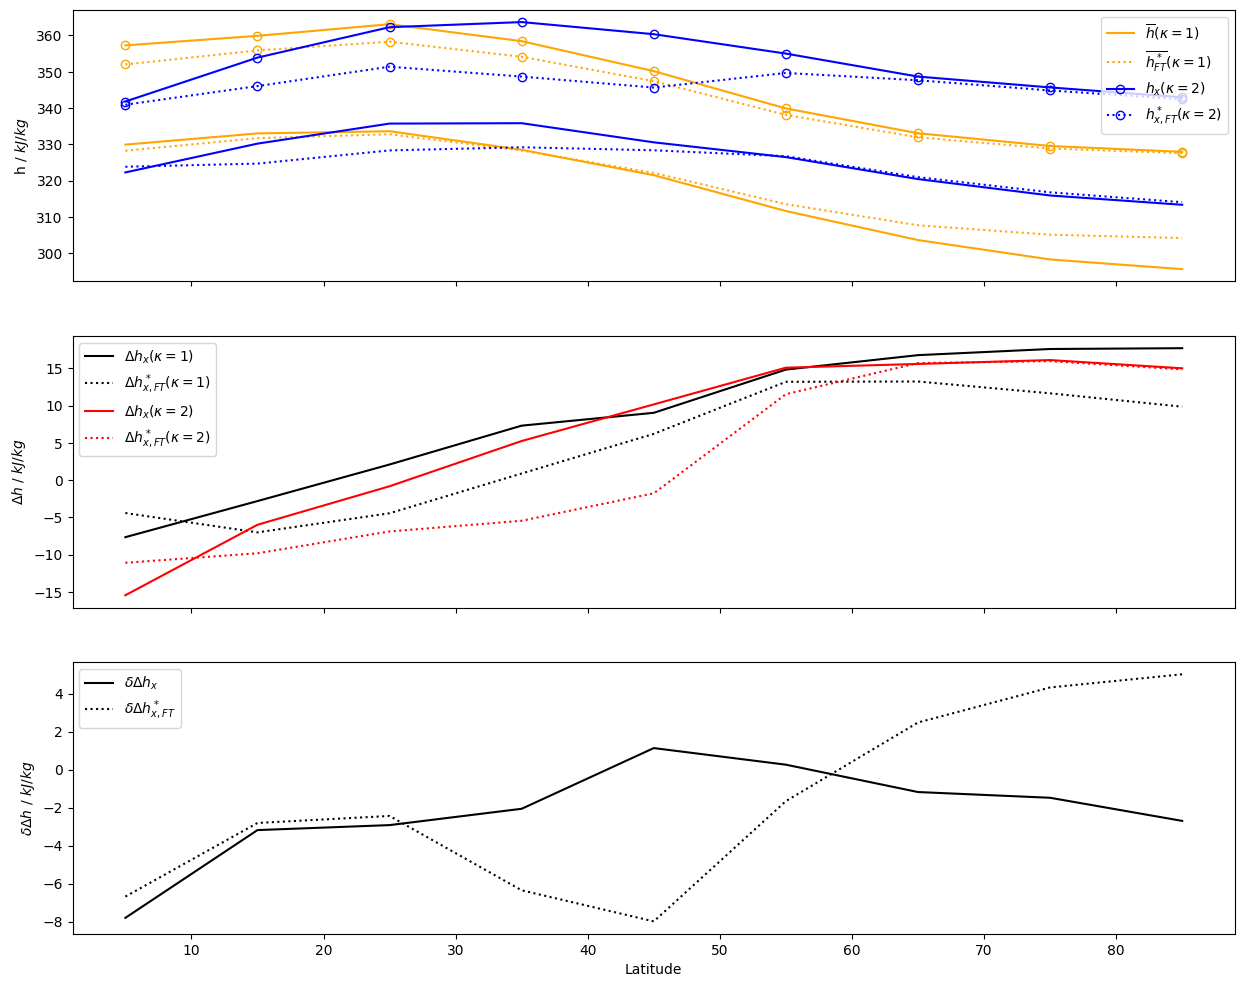

In [14]:
# Check to what extent surface and free troposphere saturated MSE are the same for each latitude in mean and on x percentile day
fig, ax = plt.subplots(3,1, figsize=(15, 12), sharex=True)
ax[0].plot(lat_centre, mse_summer[0],
           label = '$\overline{h}'+f'(\kappa={tau_lw_ref})$', color='orange')
ax[0].plot(lat_centre, mse_ft_sat_summer[0],
           label = '$\overline{h^*_{FT}}'+f'(\kappa={tau_lw_ref})$', color='orange', linestyle=':')
ax[0].plot(lat_centre, mse_summer[1], marker='o', fillstyle='none', color='orange')
ax[0].plot(lat_centre, mse_ft_sat_summer[1], marker='o', fillstyle='none', color='orange', linestyle=':')

ax[0].plot(lat_centre, mse_quant[0], color='b')
ax[0].plot(lat_centre, mse_ft_sat_quant[0], color='b', linestyle=':')
ax[0].plot(lat_centre, mse_quant[1], marker='o', fillstyle='none',
           label = '$h_x'+f'(\kappa={tau_lw_warm})$', color='b')
ax[0].plot(lat_centre, mse_ft_sat_quant[1], marker='o', fillstyle='none',
           label = '$h^*_{x,FT}'+f'(\kappa={tau_lw_warm})$', color='b', linestyle=':')

ax[1].plot(lat_centre, mse_quant[0] - mse_summer[0], color='k',
           label='$\Delta h_x'+f'(\kappa={tau_lw_ref})$')
ax[1].plot(lat_centre, mse_ft_sat_quant[0] - mse_ft_sat_summer[0], color='k',
           label='$\Delta h^*_{x, FT}'+f'(\kappa={tau_lw_ref})$', linestyle=':')
ax[1].plot(lat_centre, mse_quant[1] - mse_summer[1], color='r',
           label='$\Delta h_x'+f'(\kappa={tau_lw_warm})$')
ax[1].plot(lat_centre, mse_ft_sat_quant[1] - mse_ft_sat_summer[1], color='r',
           label='$\Delta h^*_{x, FT}'+f'(\kappa={tau_lw_warm})$', linestyle=':')

ax[2].plot(lat_centre, (mse_quant[1] - mse_summer[1]) - (mse_quant[0] - mse_summer[0]), color='k',
           label='$\delta \Delta h_x$')
ax[2].plot(lat_centre, (mse_ft_sat_quant[1] - mse_ft_sat_summer[1]) - (mse_ft_sat_quant[0] - mse_ft_sat_summer[0]),
           color='k', linestyle=':', label='$\delta \Delta h^*_{x, FT}$')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel('h / $kJ/kg$')
ax[1].set_ylabel('$\Delta h$ / $kJ/kg$')
ax[2].set_ylabel('$\delta \Delta h$ / $kJ/kg$')
ax[2].set_xlabel('Latitude');

Delving into the $\epsilon$ terms, the plot below shows that the reason for the overestimate of $\delta \Delta h_{x, FT}^*$ at high latitudes is that the $\delta \overline{\epsilon}$ is larger than the $\delta \epsilon_x$ term.

Looking at the top plot below, this may be related to the fact that for the $\kappa=1$ climate, all $\epsilon$ values are positive (i.e. the surface MSE exceeds the free troposphere MSE) except for the mean climate at the highest latitudes.

So maybe the negative $\overline{\epsilon}(\kappa = 1)$ value indicates a regime change.

Looking at the lower latitudes, we see that the $\delta \epsilon_x$ is larger than the $\delta \overline{\epsilon}$ term i.e. as we warm the climate, on the $x$ percentile day over land, the surface MSE increases much more than the free troposphere saturated MSE. For the mean day over ocean though, the increase in surface and free troposphere MSE are pretty similar.

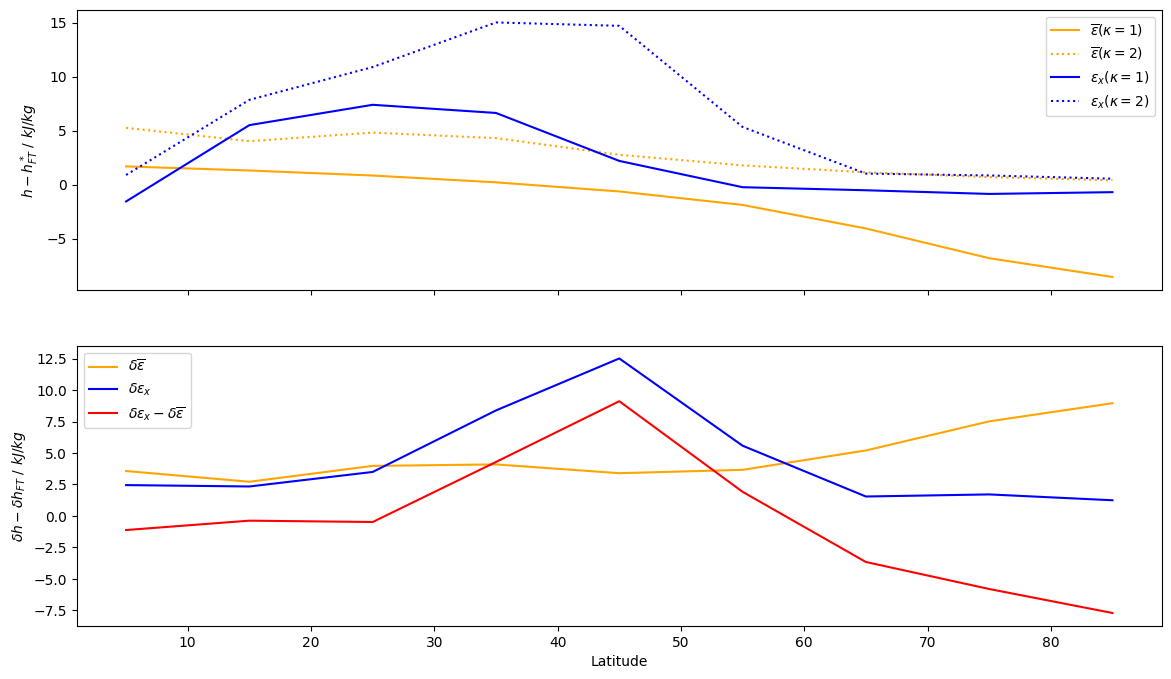

In [46]:
epsilon_quant = mse_quant - mse_ft_sat_quant
epsilon_mean = mse_summer - mse_ft_sat_summer
delta_epsilon_mean = epsilon_mean[1]-epsilon_mean[0]
delta_epsilon_quant = epsilon_quant[1]-epsilon_quant[0]

fig, ax = plt.subplots(2,1, figsize=(14, 8), sharex=True)
ax[0].plot(lat_centre, epsilon_mean[0], color='orange', label='$\overline{\epsilon}'+f'(\kappa={tau_lw_ref})$')
ax[0].plot(lat_centre, epsilon_mean[1], color='orange', linestyle=':', label='$\overline{\epsilon}'+f'(\kappa={tau_lw_warm})$')
ax[0].plot(lat_centre, epsilon_quant[0], color='b', label='$\epsilon_x'+f'(\kappa={tau_lw_ref})$')
ax[0].plot(lat_centre, epsilon_quant[1], color='b', linestyle=':', label='$\epsilon_x'+f'(\kappa={tau_lw_warm})$')

ax[1].plot(lat_centre, delta_epsilon_mean, color='orange', label='$\delta \overline{\epsilon}$')
ax[1].plot(lat_centre, delta_epsilon_quant, color='blue', label='$\delta \epsilon_x$')
ax[1].plot(lat_centre, delta_epsilon_quant - delta_epsilon_mean, color='r',
           label='$\delta \epsilon_x - \delta \overline{\epsilon}$')
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$h - h^*_{FT}$ / $kJ/kg$')
ax[1].set_ylabel('$\delta h - \delta h_{FT}$ / $kJ/kg$')
ax[1].set_xlabel('Latitude');

### Feature 2
This pattern of overestimate - underestimate - overestimate trend of $\delta T_x$ with latitude when excluding the $\delta \Delta h^*_{x, FT}$ term just reflects the fact that $\delta \Delta h_x$ starts off negative, then goes positive before becoming negative again, as shown by the black curves above.

### Feature 3
Theory 2 states that $h_x = \overline{h} + \Delta h_{x,FT}^*$. From the feature 1 analysis, we know that the exact value of $h_x$ is $h_x = \overline{h} + \Delta h_{x,FT}^* + \epsilon_x - \overline{\epsilon}$.

So Theory 2 is really assuming that $\epsilon_x = \overline{\epsilon}$ and they remain equal as the climate ($\kappa$) changes: $\delta \epsilon_x = \delta \overline{\epsilon}$; whereas Theory 4 only requires the latter assumption.

If the $\epsilon_x - \overline{\epsilon}$ terms were retained, the $\delta T_x$ equation would have the additional term: $\frac{1}{c_p}(\delta \epsilon_x - \delta \overline{\epsilon})$.

Hence, we expect Theory 2 to overestimate $\delta T_x$ by $-\frac{1}{c_p}(\delta \epsilon_x - \delta \overline{\epsilon})$ and as shown below, this results in an obvious underestimate at low latitudes and overestimate at high latitudes.

The overestimate from Theory 4 is less as it is equal to $-\frac{1}{c_p+L_v\alpha_x(q_x + q_x^* \delta r_x)}(\delta \epsilon_x - \delta \overline{\epsilon})$.
The denominator is larger than $c_p$ hence the smaller overestimate.

Overall, I think it is clear from the above plots that the assumption of $\delta \epsilon_x = \delta \overline{\epsilon}$ is more strongly met than the assumption of $\epsilon_x = \overline{\epsilon}$, hence Theory 4 is better.


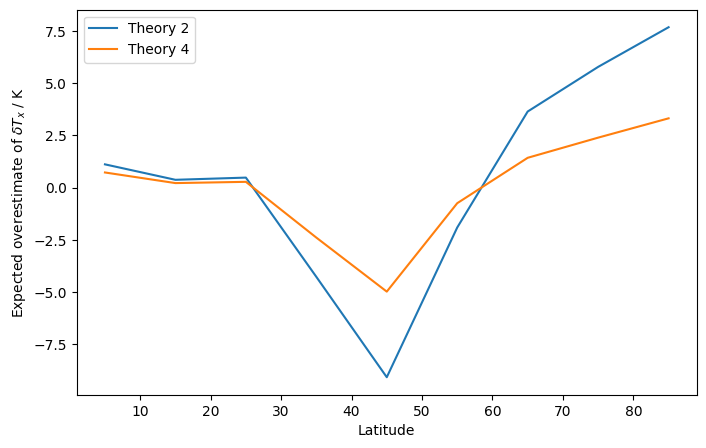

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(lat_centre, -(delta_epsilon_quant - delta_epsilon_mean) * 1000 / c_p, label='Theory 2')
ax.plot(lat_centre, -(delta_epsilon_quant - delta_epsilon_mean) * 1000 / denom, label='Theory 4')
ax.set_xlabel('Latitude')
ax.set_ylabel('Expected overestimate of $\delta T_x$ / K')
ax.legend();

## Link between $\epsilon$ and CAPE and CIN

The plot below shows that there is a strong correlation between $\epsilon$ and CAPE, as expected. If it was convectively neutral, then we would expect the CAPE would be 0. Clearly, this is not the case though.

Because the units of CAPE are $J/kg$ not $kJ/kg$, $\epsilon$ is around a factor of 10 larger than CAPE.

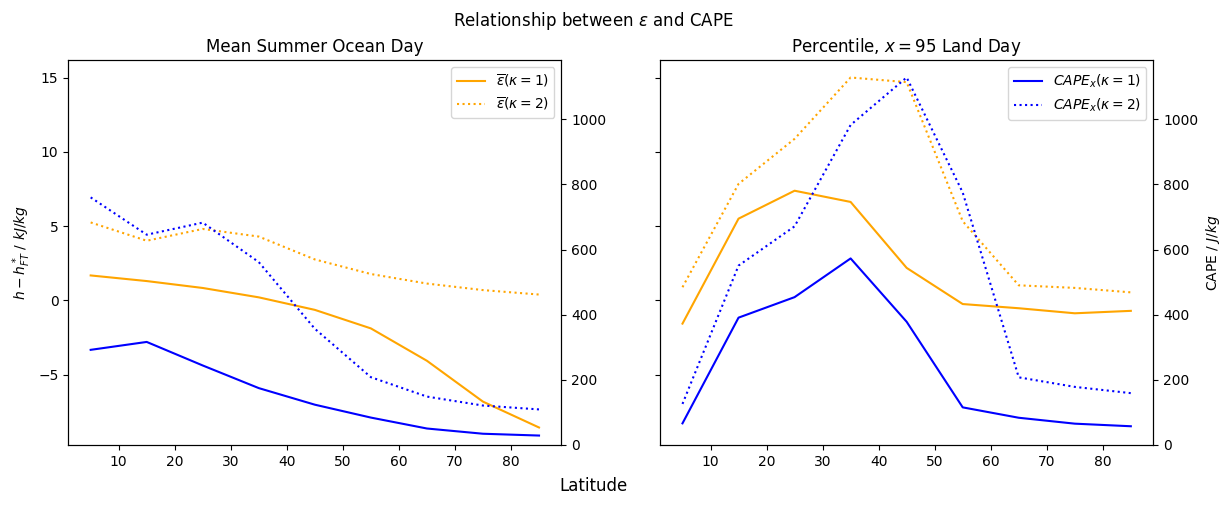

In [45]:
cape_mean = np.zeros((n_exp, n_lat))
cape_quant = np.zeros((n_exp, n_lat))
for i in range(n_exp):
    cape_mean[i] = [ds_summer[i][j].cape for j in range(n_lat)]
    cape_quant[i] = [ds_quant[i][j].cape for j in range(n_lat)]

fig, ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
ax[0].plot(lat_centre, epsilon_mean[0], color='orange', label='$\overline{\epsilon}'+f'(\kappa={tau_lw_ref})$')
ax[0].plot(lat_centre, epsilon_mean[1], color='orange', linestyle=':', label='$\overline{\epsilon}'+f'(\kappa={tau_lw_warm})$')
ax[1].plot(lat_centre, epsilon_quant[0], color='orange', label='$\epsilon_x'+f'(\kappa={tau_lw_ref})$')
ax[1].plot(lat_centre, epsilon_quant[1], color='orange', linestyle=':', label='$\epsilon_x'+f'(\kappa={tau_lw_warm})$')
ax2=ax[0].twinx()
ax2.plot(lat_centre, cape_mean[0], color='b', label='$\overline{CAPE}'+f'(\kappa={tau_lw_ref})$')
ax2.plot(lat_centre, cape_mean[1], color='b', linestyle=':', label='$\overline{CAPE}'+f'(\kappa={tau_lw_warm})$')
ax3 = ax[1].twinx()
ax3.plot(lat_centre, cape_quant[0], color='b', label='$CAPE_x'+f'(\kappa={tau_lw_ref})$')
ax3.plot(lat_centre, cape_quant[1], color='b', linestyle=':', label='$CAPE_x'+f'(\kappa={tau_lw_warm})$')
ax2.set_ylim([0, ax3.get_ylim()[1]])
ax3.set_ylim([0, ax3.get_ylim()[1]])
ax[0].legend()
ax3.legend()
fig.supxlabel('Latitude')
ax[0].set_ylabel('$h - h^*_{FT}$ / $kJ/kg$')
ax3.set_ylabel('CAPE / $J/kg$')
ax[0].set_title('Mean Summer Ocean Day')
ax[1].set_title(f'Percentile, $x={quantile_use}$ Land Day ')
fig.suptitle('Relationship between $\epsilon$ and CAPE');

The plot below shows that CIN is much smaller than the CAPE, implying that below the LCL, the temperature profile is very close to the dry adiabat.

The fact that the absolute value of CIN is larger for the high percentile land day than the mean ocean day in the tropics implies that the environmental lapse rate is smaller than the dry adiabat (closer to the moist adiabat) meaning that for a given change in altitude or pressure, the temperature change is less than expected from the dry adiabat.

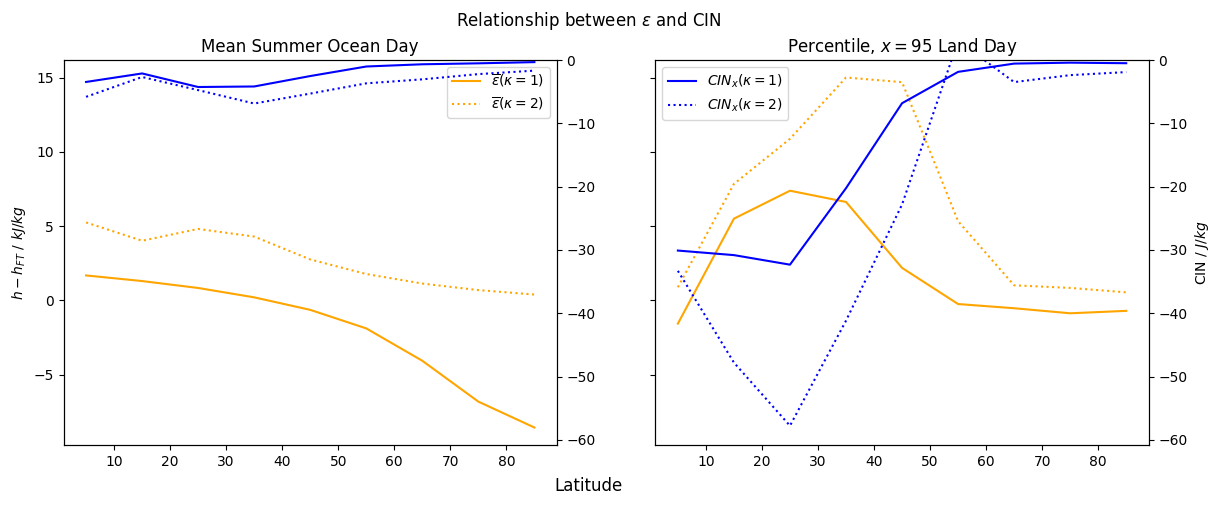

In [40]:
cin_mean = np.zeros((n_exp, n_lat))
cin_quant = np.zeros((n_exp, n_lat))
for i in range(n_exp):
    cin_mean[i] = [ds_summer[i][j].cin for j in range(n_lat)]
    cin_quant[i] = [ds_quant[i][j].cin for j in range(n_lat)]

fig, ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
ax[0].plot(lat_centre, epsilon_mean[0], color='orange', label='$\overline{\epsilon}'+f'(\kappa={tau_lw_ref})$')
ax[0].plot(lat_centre, epsilon_mean[1], color='orange', linestyle=':', label='$\overline{\epsilon}'+f'(\kappa={tau_lw_warm})$')
ax[1].plot(lat_centre, epsilon_quant[0], color='orange', label='$\epsilon_x'+f'(\kappa={tau_lw_ref})$')
ax[1].plot(lat_centre, epsilon_quant[1], color='orange', linestyle=':', label='$\epsilon_x'+f'(\kappa={tau_lw_warm})$')
ax2=ax[0].twinx()
ax2.plot(lat_centre, cin_mean[0], color='b', label='$\overline{CAPE}'+f'(\kappa={tau_lw_ref})$')
ax2.plot(lat_centre, cin_mean[1], color='b', linestyle=':', label='$\overline{CAPE}'+f'(\kappa={tau_lw_warm})$')
ax3 = ax[1].twinx()
ax3.plot(lat_centre, cin_quant[0], color='b', label='$CIN_x'+f'(\kappa={tau_lw_ref})$')
ax3.plot(lat_centre, cin_quant[1], color='b', linestyle=':', label='$CIN_x'+f'(\kappa={tau_lw_warm})$')
ax2.set_ylim([ax3.get_ylim()[0], 0])
ax3.set_ylim([ax3.get_ylim()[0], 0])
ax[0].legend()
ax3.legend()
fig.supxlabel('Latitude')
ax[0].set_ylabel('$h - h_{FT}$ / $kJ/kg$')
ax3.set_ylabel('CIN / $J/kg$')
ax[0].set_title('Mean Summer Ocean Day')
ax[1].set_title(f'Percentile, $x={quantile_use}$ Land Day ')
fig.suptitle('Relationship between $\epsilon$ and CIN');

## Comparison to Aquaplanet Simulations
Compared to the theories applied to the [aquaplanet](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/aquaplanet/temp_quant_theory_latitude.ipynb) simulations, over land they do significantly worse.

This is because the assumption that $\delta \epsilon_x = \delta \overline{\epsilon}$ is very good in the aquaplanet at low latitudes, but this is not the case for land, where $\delta \epsilon_x > \delta \overline{\epsilon}$.

We can see this in the plot below, where at the free troposphere pressure of 700hPa, the difference between the actual temperature profile (blue) and the convectively neutral profile (red) for the mean ocean day remains approximately the same for $\kappa=1$ and $\kappa=2$ i.e. $\delta \overline{\epsilon} = 0$.

But the difference between the actual temperature profile (green) and the convectively neutral profile (yellow) for the $x$ percentile land day increases as we got from $\kappa=1$ to $\kappa=2$ i.e. $\delta \epsilon_x > 0$.

In [41]:
lat_plot = 0
lat_plot_ind = np.argmin(np.abs(lat_centre-lat_plot))

temp_profile_summer = [convection_neutral_profile(float(ds_summer[i][lat_plot_ind].temp[-1]), p_surface,
                                                  float(ds_summer[i][lat_plot_ind].sphum[-1]),
                                                  ds_summer[i][lat_plot_ind].temp.pfull.to_numpy()*100) for i in range(n_exp)]

temp_profile_quant = [convection_neutral_profile(float(ds_quant[i][lat_plot_ind].temp[-1]), p_surface,
                                                 float(ds_quant[i][lat_plot_ind].sphum[-1]),
                                                 ds_quant[i][lat_plot_ind].temp.pfull.to_numpy()*100) for i in range(n_exp)]

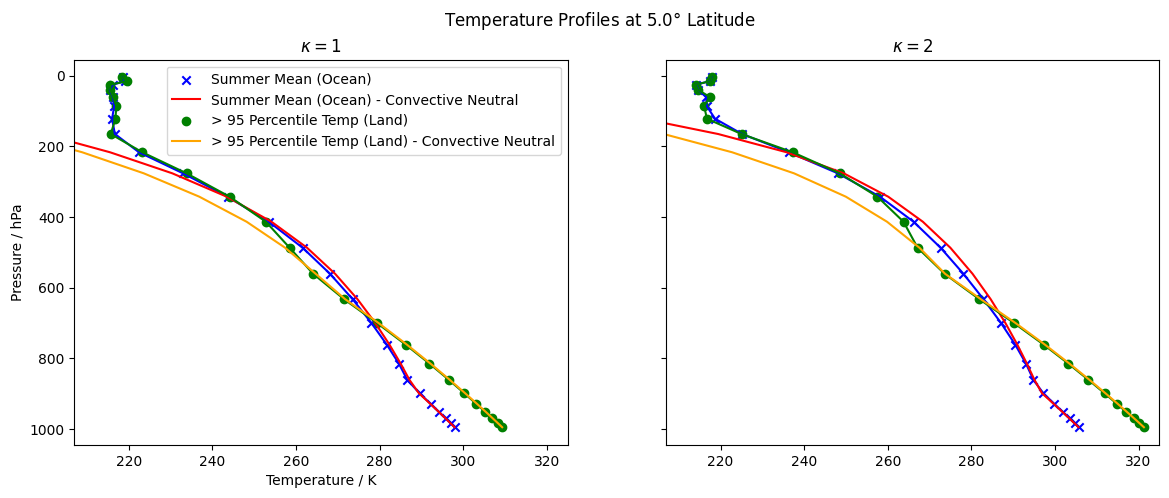

In [42]:
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
for i in range(n_exp):
    axs[i].plot(ds_summer[i][lat_plot_ind].temp.to_numpy(), ds_summer[i][lat_plot_ind].temp.pfull.to_numpy(), color='b')
    axs[i].scatter(ds_summer[i][lat_plot_ind].temp.to_numpy(), ds_summer[i][lat_plot_ind].temp.pfull.to_numpy(),
                   label='Summer Mean (Ocean)', color='b', marker='x')
    axs[i].plot(temp_profile_summer[i], ds_summer[i][lat_plot_ind].pfull.to_numpy(), label='Summer Mean (Ocean) - Convective Neutral',
                color='r')

    axs[i].plot(ds_quant[i][lat_plot_ind].temp.to_numpy(), ds_quant[i][lat_plot_ind].temp.pfull.to_numpy(), color='g')
    axs[i].scatter(ds_quant[i][lat_plot_ind].temp.to_numpy(), ds_quant[i][lat_plot_ind].temp.pfull.to_numpy(), color='g', marker='o',
                   label=f'> {quantile_use} Percentile Temp (Land)')
    axs[i].plot(temp_profile_quant[i], ds_quant[i][lat_plot_ind].temp.pfull.to_numpy(), color='orange',
                label=f'> {quantile_use} Percentile Temp (Land) - Convective Neutral')

axs[0].invert_yaxis()
axs[0].set_xlim([207, 325])
# axs[0].set_xlim([275, 292])
# axs[0].set_ylim([pressure_ft+50, pressure_ft-50])
axs[0].legend()
axs[0].set_xlabel('Temperature / K')
axs[0].set_ylabel('Pressure / hPa')
axs[0].set_title(f'$\kappa = {tau_lw_ref}$')
axs[1].set_title(f'$\kappa = {tau_lw_warm}$')
fig.suptitle(f'Temperature Profiles at ${lat_centre[lat_plot_ind]}\degree$ Latitude');

### Temperature Profiles
Look at temperature profiles on single days with no averaging, that have high temperatures. I thought maybe issue could be that I am computing LCL and moist adiabat using average specific humidity and average temperature. But, for example the relative humidity computed on each day and then averaged is different to the relative humidity computed using the average specific humidity and average temperature.

In [20]:
lat_plot = 40
lon_plot = 0
hot_temp_thresh = 304

ds_use = ds_all['land'][0].sel(time=slice(use_time_start, np.inf))     # Only use after converged
ds_use = ds_use.sel(lat=lat_plot, lon=lon_plot, method='nearest')
times_warm_days = ds_use.time[np.where(ds_use.temp.sel(pfull=np.inf, method='nearest').to_numpy()>hot_temp_thresh)[0]].to_numpy()
print(f'Number of warm days = {len(times_warm_days)}')

Number of warm days = 13


In [21]:
ds_use2 = ds_use.sel(time=times_warm_days[5], method='nearest')
# ds_use2 = ds_use2.sel(time=852.5, method='nearest')
temp_plot = ds_use2.temp.to_numpy()
p_plot = ds_use2.pfull.to_numpy()

temp_plot_theory = convection_neutral_profile(float(ds_use2.temp[-1]), float(ds_use2.pfull[-1]*100),
                                                  float(ds_use2.sphum[-1]),
                                                  p_plot*100)
lcl_temp_theory = lcl_temp(float(ds_use2.temp[-1]), float(ds_use2.pfull[-1]*100), float(ds_use2.sphum[-1]))
surface_rh_plot = rh_from_sphum(float(ds_use2.sphum[-1]), float(ds_use2.temp[-1]), float(ds_use2.pfull[-1]*100))

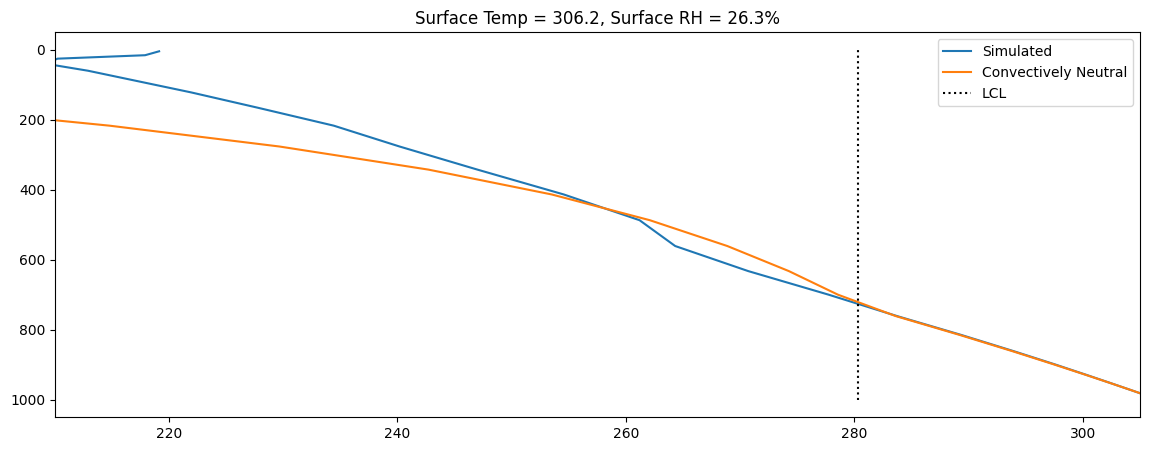

In [22]:
fig, ax = plt.subplots(1,1, figsize=(14, 5))
ax.plot(temp_plot, p_plot, label='Simulated')
ax.plot(temp_plot_theory, p_plot, label='Convectively Neutral')
ax.invert_yaxis()
ax.set_xlim([210,305])
ax.vlines([lcl_temp_theory], 1000, 0, label='LCL', color='k', linestyles=':')
ax.set_title('Surface Temp = {:.1f}, Surface RH = {:.1f}%'.format(float(ds_use2.temp[-1]), surface_rh_plot))
ax.legend();